# Emotion Classification using DistilBERT

In [ ]:
# !pip install --upgrade transformers datasets
import os
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    default_data_collator
)

In [3]:
# Constants
MODEL_NAME = 'distilbert-base-uncased'
NUM_LABELS = 6
MAX_LENGTH = 128
NUM_EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
CHECKPOINT_DIR = './checkpoints'

# Ensure checkpoint directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model and tokenizer setup
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS).to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def preprocess_function(examples: Dict[str, List]) -> Dict[str, List]:
    """Tokenize and prepare the examples for model input."""
    result = tokenizer(
        examples['text'],
        padding='max_length',
        max_length=MAX_LENGTH,
        truncation=True
    )
    result['label'] = examples['label']
    return result

def evaluate(model: nn.Module, data_loader: DataLoader) -> Tuple[float, float]:
    """Evaluate the model on the given data loader."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def save_checkpoint(model: nn.Module, optimizer: torch.optim.Optimizer,
                    epoch: int, loss: float, accuracy: float):
    """Save a checkpoint of the model."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(checkpoint, f'{CHECKPOINT_DIR}/checkpoint_epoch_{epoch}.pt')

In [5]:
# Load and preprocess data
print("Loading and preprocessing data...")
dataset = load_dataset('dair-ai/emotion')
preprocessed_dataset = dataset.map(preprocess_function, batched=True)

# Create train and validation sets
train_set = preprocessed_dataset['train'].shuffle(seed=42)
val_set = preprocessed_dataset['validation'].shuffle(seed=42)

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=default_data_collator
)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=default_data_collator
)

Loading and preprocessing data...


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0,
    num_training_steps=len(train_loader) * NUM_EPOCHS
)

# Metrics tracking
metrics = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

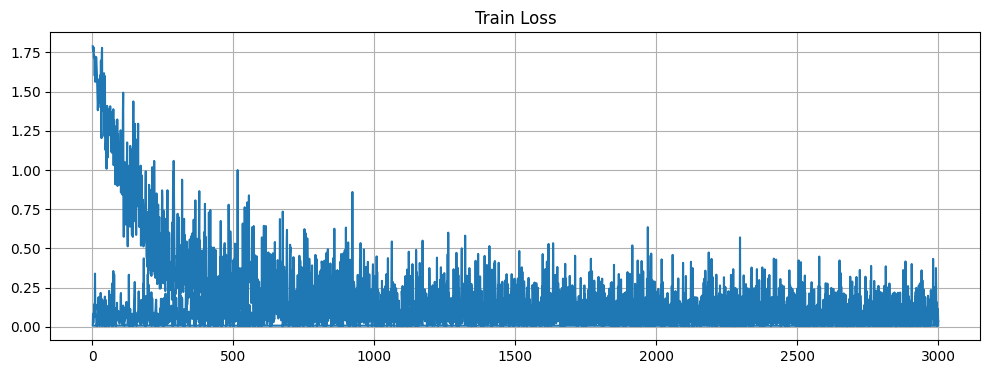

Epoch 3/3, Step 3000
Current loss: 0.0384
Mean loss (last 100 steps): 0.0808
Val loss: 0.12999268814362586
Val accuracy: 0.9395
Training completed!


In [12]:
# Training loop
print("Starting training...")
global_step = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        batch = {k: v.to(device) for k, v in batch.items() if k != 'text'}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        global_step += 1
        epoch_loss += loss.item()
        metrics['train_loss'].append((global_step, loss.item()))

        # Update plot every 20 steps
        if global_step % 20 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 1, 1)
            plt.title('Train Loss')
            plt.plot(*zip(*metrics['train_loss']))
            plt.grid()
            plt.show()
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Step {global_step}")
            print(f"Current loss: {loss.item():.4f}")
            print(f"Mean loss (last 100 steps): {np.mean([x[1] for x in metrics['train_loss'][-100:]]):.4f}")

    avg_train_loss = epoch_loss / len(train_loader)

    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f"Val loss: {val_loss}")
    print(f"Val accuracy: {val_accuracy}")

    # Save checkpoint
    save_checkpoint(model, optimizer, epoch+1, val_loss, val_accuracy)

print("Training completed!")

In [15]:
from google.colab import drive
import shutil


drive.mount('/content/drive')

destination_dir = '/content/drive/My Drive/model_checkpoints'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)


source_dir = '/content/checkpoints'
destination_dir = '/content/drive/My Drive/model_checkpoints'

# Copy all files from source to destination
for filename in os.listdir(source_dir):
    source_file = os.path.join(source_dir, filename)
    destination_file = os.path.join(destination_dir, filename)
    shutil.copy2(source_file, destination_file)
    print(f"Copied {filename} to Google Drive")

Mounted at /content/drive
Copied checkpoint_epoch_1.pt to Google Drive
Copied checkpoint_epoch_2.pt to Google Drive
Copied checkpoint_epoch_3.pt to Google Drive
